In [265]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm



In [307]:
class Particle:
    
    def __init__(self, r0, v0, a0, t, m=1, radius=2., Id=0):
        
        self.dt = t[1] - t[0]
        
        
        # Atributos instantaneos
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.m = m
        self.radius = radius
        self.Id = Id
        
        
        self.p = self.m*self.v
        
        self.f = self.m*self.a
        
        # Historial
        
        self.R = np.zeros((len(t),len(r0)))
        self.V = np.zeros_like(self.R)
        self.A = np.zeros_like(self.R)
        
        self.F = np.zeros_like(self.R)
        
        self.P = np.zeros_like(self.R)
    
        # Fisica
        self.K = 20.
        
        self.VEk = np.zeros(len(t))
        self.Ep = 0
        self.VEp = np.zeros(len(t))
        
    def Evolution(self,i):
        
        
        self.SetPosition(i)
        self.SetVelocity(i)
        
        self.a = self.f/self.m
        self.SetPotentialEnergy(i)
        
        # Euler-Cromer
        self.v += self.dt*self.a
        self.r += self.dt*self.v
        
        
    def CalculateForce(self):
        
        self.f = self.m*np.array([0,-9.8])
        self.Ep += self.m*9.8*self.r[1]
        
    # Aca debes agregar la energía potencial
    
    def ResetForce(self):
        self.f[:] = 0.
        self.a[:] = 0.
        self.Ep = 0.
    
    # Setter
    def SetPosition(self,i):
        self.R[i] = self.r
    
    def SetVelocity(self,i):
        self.V[i] = self.v
        self.P[i] = self.m*self.v
        self.VEk[i] = 0.5*self.m*np.dot(self.v,self.v)
        
    def SetPotentialEnergy(self,i):
        self.VEp[i] = self.Ep
        
    # Getter
    def GetPosition(self,scale=1):
        return self.R[::scale]
    
    def GetVelocity(self,scale=1):
        return self.V[::scale]
 
    def GetMomentum(self,scale=1):
        return self.P[::scale]
    
    def GetKineticEnergy(self,scale=1):
        return self.VEk[::scale] 
    
    def GetPotentialEnergy(self,scale=1):
        return self.VEp[::scale] 
    
    # Debes agregar las paredes en este punto
    def CheckLimits(self):
        
        for i in range(2):
            
            if self.r[i] + self.radius > 40 and self.v[i] > 0.:
                self.v[i] = self.v[i]*-0.9
            elif self.r[i] - self.radius < -40 and self.v[i] < 0.:
                self.v[i] = self.v[i]*-0.9
    

In [308]:
def GetParticles(t):
    
    r0 = np.array([-15.,-10.])
    v0 = np.array([2.,0])
    a0 = np.array([0.,0.])
    
    p0 = Particle(r0,v0,a0,t,m=1,radius=2,Id=0)
    
    Particles = [p0]
    
    # Aca deber agregar una rutina montecarlo para crear particulas
    # sobre el plano con velocidades aleatorias.
    
    return Particles

In [309]:
dt = 0.001
tmax = 30
t = np.arange(0,tmax,dt)
Particles = GetParticles(t)

In [310]:
def RunSimulation(t,Particles):
    
    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ):
        
        for i in range(len(Particles)):
                    Particles[i].CalculateForce()
        
        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            Particles[i].ResetForce()
            Particles[i].CheckLimits()
            # Aca debes agregar la interaccion con la pared
            
            
    return Particles

In [311]:
Particles = RunSimulation(t,Particles)


Running simulation: 100%|█████████████████████████████████████████████████| 30000/30000 [00:00<00:00, 31656.91 Steps/s]


In [312]:
# Bajamos dimensión de la simulacion
scale = 100
t1 = t[::scale]

<IPython.core.display.Javascript object>


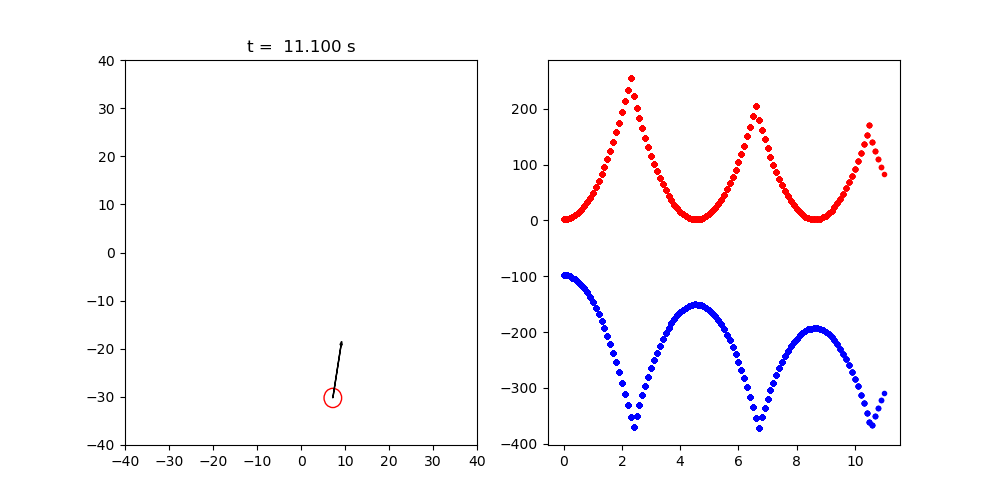

In [313]:

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

def init():
    
    ax.clear()
    ax.set_xlim(-40,40)
    ax.set_ylim(-40,40)
    
def Update(i):
    
    init()
    ax.set_title(r't =  %.3f s' %(t1[i]))
    
    
    # Queremos calcular la energía total de cinética
    KE = 0. # Kinetic energy
    U = 0. # Potential energy
    
    for p in Particles:
        
        x = p.GetPosition(scale)[i,0]
        y = p.GetPosition(scale)[i,1]
        
        vx = p.GetVelocity(scale)[i,0]
        vy = p.GetVelocity(scale)[i,1]
        
        circle = plt.Circle( (x,y), p.radius, color='r', fill=False )
        ax.add_patch(circle)
        
        ax.arrow(x,y,vx,vy,color='k',head_width=0.5,length_includes_head=True)
        
        KE += p.GetKineticEnergy(scale)[i]
        U +=p.GetPotentialEnergy(scale)[i]
        
        M = p.GetPotentialEnergy(scale)[:i] + p.GetKineticEnergy(scale)[:i]
        
        #ax1.set_title("K: {:.3f}, U: {:.3f}, M:{:.3f}".format(KE,Um,M))
        ax1.scatter(t1[:i], p.GetKineticEnergy(scale)[:i],color='red',marker='.')
        ax1.scatter(t1[:i], p.GetPotentialEnergy(scale)[:i],color='blue',marker='.')
        #ax1.scatter(t1[:i], M ,color='green',marker='.')
            
Animation = anim.FuncAnimation(fig,Update,frames=len(t1),init_func=init)